In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [684]:
import re # We clean text using regex
import csv # To read the csv
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
import gensim
from sklearn.preprocessing import MinMaxScaler

In [354]:
import spacy
# !python -m spacy download en

In [355]:
import warnings
warnings.filterwarnings(action='ignore')

In [356]:
import nltk
# nltk.download('stopwords')

In [382]:
data=pd.read_csv('amazon_reviews_data.csv')
data

,author,title,date,content,rating
0,Christine,impossible to understand intercom messages and...,31-Jan-19,The echo dot 2nd generation worked perfectly a...,1
1,Amazon Customer,Not that smart,15-Mar-19,I thought it would be smarter than it is. I h...,3
2,Amazon Customer,nowhere near as nice as the tower,02-May-19,the volume is very low in comparison to the to...,2
3,Jammy Dodger,Very disappointing compared to previous models,04-Dec-18,"I have 2 original echo dots, a first gen Echo ...",2
4,Richard,Prepare to be frustrated - inconsistant functi...,27-Apr-19,I purchased two 3rd generation dots primarily ...,2
...,...,...,...,...,...
15456,j.r.fellabaum,Take Alexa With You via your phone as a wifi h...,19-Mar-19,See my other post....using this one in my car ...,5
15457,Amazon Customer,Make all my purchases with Amazon,30-Mar-19,What did I like about this product? Love love ...,5
15458,candace j. cavanaugh,Fun!,03-May-19,I bought the echo on a whim and I am so glad I...,5
15459,Kaitlin Reitz,Great product,05-Apr-19,Got this free with our Ring doorbell. We alrea...,5


In [358]:
data['rating'].describe()

count    15461.000000
mean         4.176121
std          1.222562
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [359]:
data['author'].value_counts()

Amazon Customer    1274
Kindle Customer      91
Chris                24
John                 24
Michael              23
                   ... 
Judy C.               1
Lizzy Busy            1
iamforce              1
ANN H.                1
Patrice Harzke        1
Name: author, Length: 12604, dtype: int64

### Gensim LDA


In [383]:
data=data.replace(r'[^\w\s]','',regex=True)

In [384]:
stopwords = set(stopwords.words('english'))

In [385]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [386]:
token_word=list(sent_to_words(data['content']))

In [387]:
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [388]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(token_word, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[token_word], threshold=100)
 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
 
# See trigram example
print(trigram_mod[bigram_mod[token_word[0]]])

['the', 'echo', 'dot', 'nd', 'generation', 'worked', 'perfectly', 'as', 'an', 'intercom', 'using', 'the', 'drop', 'in', 'command', 'the', 'rd', 'generation', 'echo', 'dot', 'has', 'the', 'audio', 'going', 'in', 'and', 'out', 'mid', 'sentence', 'making', 'it', 'impossible', 'to', 'understand', 'the', 'echo', 'as', 'an', 'intercom', 'as', 'time', 'went', 'on', 'the', 'rd', 'generation', 'speaker', 'did', 'not', 'get', 'any', 'clearer', 'swapping', 'out', 'one', 'rd', 'generation', 'for', 'another', 'did', 'not', 'solve', 'the', 'problems', 'with', 'clarity', 'the', 'rd', 'generation', 'has', 'problems', 'when', 'two', 'people', 'are', 'talking', 'more', 'than', 'the', 'nd', 'generation', 'also', 'music', 'playing', 'on', 'either', 'side', 'of', 'the', 'connection', 'will', 'cause', 'problems', 'with', 'message', 'clarity', 'on', 'the', 'rd', 'generation', 'echo', 'dot', 'the', 'rd', 'generation', 'device', 'rather', 'than', 'learning', 'your', 'voice', 'and', 'distinguishing', 'when', 'y

In [389]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
 
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [390]:
import en_core_web_sm


# Remove Stop Words
data_words_nostops = remove_stopwords(token_word)
 
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
 
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = en_core_web_sm.load()
 
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
print(data_lemmatized[:1])

[['generation', 'work', 'perfectly', 'intercom', 'use', 'dot', 'audio', 'go', 'mid', 'sentence', 'make', 'impossible', 'understand', 'go', 'generation', 'clear', 'swap', 'generation', 'solve', 'problem', 'clarity', 'generation', 'problem', 'people', 'talk', 'generation', 'also', 'music', 'play', 'side', 'connection', 'cause', 'problem', 'message', 'clarity', 'generation', 'dot', 'rd', 'generation', 'device', 'rather', 'learn', 'voice', 'distinguishing', 'talk', 'subtracting', 'interfere', 'message', 'clarity', 'dot', 'much', 'music', 'people', 'talk', 'time', 'cause', 'speaker', 'garble', 'message', 'generation', 'generation', 'rely', 'training', 'user', 'turn', 'music', 'wait', 'patiently', 'person', 'end', 'talk', 'customer', 'expect', 'artificial', 'intelligent', 'device', 'service', 'responsive', 'polite', 'make', 'overture', 'correct', 'problem', 'however', 'promise', 'call', 'back', 'make', 'even', 'schedule', 'give', 'call', 'number', 'email', 'respond', 'add', 'additional', 'co

In [328]:
# Remove Stop Words
data_words_nostops = remove_stopwords(token_word)

In [329]:
data_words_nostops

[['echo',
  'dot',
  'nd',
  'generation',
  'worked',
  'perfectly',
  'intercom',
  'using',
  'drop',
  'command',
  'rd',
  'generation',
  'echo',
  'dot',
  'audio',
  'going',
  'mid',
  'sentence',
  'making',
  'impossible',
  'understand',
  'echo',
  'intercom',
  'time',
  'went',
  'rd',
  'generation',
  'speaker',
  'get',
  'clearer',
  'swapping',
  'one',
  'rd',
  'generation',
  'another',
  'solve',
  'problems',
  'clarity',
  'rd',
  'generation',
  'problems',
  'two',
  'people',
  'talking',
  'nd',
  'generation',
  'also',
  'music',
  'playing',
  'either',
  'side',
  'connection',
  'cause',
  'problems',
  'message',
  'clarity',
  'rd',
  'generation',
  'echo',
  'dot',
  'rd',
  'generation',
  'device',
  'rather',
  'learning',
  'voice',
  'distinguishing',
  'talk',
  'subtracting',
  'background',
  'noise',
  'background',
  'noise',
  'interfere',
  'message',
  'clarity',
  'nd',
  'generation',
  'echo',
  'dot',
  'much',
  'background',
  '

In [391]:
# Create Dictionary

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 5), (10, 2), (11, 1), (12, 3), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 2), (26, 2), (27, 1), (28, 3), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 2), (37, 3), (38, 1), (39, 1), (40, 18), (41, 2), (42, 3), (43, 1), (44, 1), (45, 10), (46, 1), (47, 2), (48, 8), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 3), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 4), (62, 1), (63, 11), (64, 2), (65, 2), (66, 3), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 4), (76, 3), (77, 1), (78, 2), (79, 1), (80, 2), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 2), (93, 3), (94, 1), (95, 2), (96, 3), (97, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 1), (105, 1), (106, 2), (107, 2), (108, 2), (109, 1), (110,

In [392]:
id2word[0]

'ability'

In [393]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('actual', 1),
  ('add', 1),
  ('additional', 2),
  ('address', 1),
  ('advertise', 1),
  ('alexa', 1),
  ('also', 1),
  ('announcement', 2),
  ('answer', 5),
  ('appear', 2),
  ('application', 1),
  ('artificial', 3),
  ('ass', 2),
  ('assistant', 2),
  ('audio', 1),
  ('avoidable', 1),
  ('back', 1),
  ('bargain', 1),
  ('base', 1),
  ('become', 1),
  ('bedroom', 1),
  ('bit', 1),
  ('buy', 1),
  ('call', 2),
  ('can', 2),
  ('cause', 2),
  ('channel', 1),
  ('clarity', 3),
  ('clear', 2),
  ('compatible', 1),
  ('computer', 1),
  ('concern', 2),
  ('concerned', 1),
  ('connection', 1),
  ('consider', 1),
  ('correct', 2),
  ('customer', 3),
  ('deal', 1),
  ('description', 1),
  ('device', 18),
  ('digital', 2),
  ('disconnect', 3),
  ('discount', 1),
  ('distinguishing', 1),
  ('dot', 10),
  ('drop', 1),
  ('dumb', 2),
  ('echo', 8),
  ('ed', 1),
  ('email', 1),
  ('encounter', 1),
  ('end', 1),
  ('enough', 2),
  ('equipment', 1),
  ('even', 3),
  ('expect', 3)

In [402]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=20,
random_state=12,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

In [403]:
topics = lda_model.show_topics()
for topic in topics:
    print(topic)

(17, '0.301*"expect" + 0.109*"exactly" + 0.012*"intuitive" + 0.000*"happy" + 0.000*"install" + 0.000*"ordering" + 0.000*"design" + 0.000*"used" + 0.000*"office" + 0.000*"satisfy"')
(18, '0.398*"fun" + 0.202*"add" + 0.054*"program" + 0.032*"complete" + 0.021*"info" + 0.014*"installation" + 0.003*"frequency" + 0.001*"loop" + 0.000*"amazing" + 0.000*"setup"')
(2, '0.096*"complaint" + 0.085*"several" + 0.073*"hard" + 0.070*"louder" + 0.069*"joke" + 0.050*"overall" + 0.042*"conversation" + 0.030*"real" + 0.029*"search" + 0.024*"notice"')
(8, '0.375*"listen" + 0.181*"connect" + 0.092*"like" + 0.040*"apple" + 0.032*"otherwise" + 0.030*"playlist" + 0.024*"difficult" + 0.022*"radio_station" + 0.015*"dislike" + 0.011*"entire"')
(9, '0.486*"product" + 0.058*"life" + 0.047*"soon" + 0.047*"year" + 0.022*"month" + 0.021*"replacement" + 0.020*"break" + 0.018*"integration" + 0.017*"last" + 0.016*"offer"')
(7, '0.237*"well" + 0.173*"much" + 0.071*"generation" + 0.064*"new" + 0.063*"look" + 0.045*"old" 

In [404]:
lda_model.print_topic(0)

'0.333*"easy" + 0.257*"set" + 0.076*"help" + 0.055*"app" + 0.051*"reminder" + 0.032*"timer" + 0.026*"son" + 0.026*"do" + 0.016*"remind" + 0.014*"realize"'

In [405]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.255484  0.391614       1        1  19.383824
14     0.188484 -0.223565       2        1  11.655746
4      0.138531 -0.086780       3        1   7.807701
7      0.088146 -0.020091       4        1   7.186627
6      0.137748 -0.084716       5        1   6.551282
16     0.109033 -0.053620       6        1   6.430679
13     0.110337 -0.054590       7        1   5.569411
5      0.026740 -0.009488       8        1   5.130192
19     0.002372 -0.001588       9        1   4.783048
3      0.006706 -0.003308      10        1   4.610096
15    -0.010113  0.001316      11        1   4.019349
0     -0.004050 -0.001346      12        1   3.093956
11    -0.098914  0.016118      13        1   2.756671
10    -0.094628  0.015348      14        1   2.608923
1     -0.093816  0.015098      15        1   2.371171
9     -0.093974  0.015043      16        1   2.035595
8     -0.114437  0.017288      17        1   1.675499
2     -0.179695  0.022381      18        1   1.209446
18    -0.168475  0.021788      19        1   0.872192
17    -0.205478  0.023098      20        1   0.248593, topic_info=            Term         Freq        Total Category  logprob  loglift
376         love  8544.000000  8544.000000  Default  30.0000  30.0000
180        great  6429.000000  6429.000000  Default  29.0000  29.0000
96         music  5976.000000  5976.000000  Default  28.0000  28.0000
292        sound  6338.000000  6338.000000  Default  27.0000  27.0000
45           dot  5799.000000  5799.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1752       quick     0.041864     1.995685  Topic20  -9.6402   2.1328
1001  absolutely     0.041864     1.996041  Topic20  -9.6402   2.1326
1286     amazing     0.041865     1.996736  Topic20  -9.6402   2.1323
994         size     0.041864     1.996300  Topic20  -9.6402   2.1325
1046       setup     0.041864     1.996413  Topic20  -9.6402   2.1324

[737 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        13  0.991666     ability
350       1  0.997613        able
559      15  0.872573  acceptable
829       6  0.991128      access
238      13  0.983935     account
...     ...       ...         ...
193       2  0.998788       would
577      11  0.986163       wrong
842      16  0.992133        year
624       4  0.970050        yell
215       9  0.990579         yet

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 15, 5, 8, 7, 17, 14, 6, 20, 4, 16, 1, 12, 11, 2, 10, 9, 3, 19, 18])

In [406]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.658127537569941

Coherence Score:  0.4282045960587505


In [411]:
word_dict = {};
for i in range(6):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,easy,little,complaint,home,sound,go
1,set,kid,several,need,good,could
2,help,way,hard,control,quality,purchase
3,app,whole,louder,lot,speaker,tell
4,reminder,speak,joke,pretty,price,give
5,timer,deal,overall,volume,bluetooth,take
6,son,leave,conversation,system,loud,come
7,do,package,real,different,version,helpful
8,remind,often,search,cool,sale,long
9,realize,communication,notice,multiple,improve,back


### Scikit-learn LDA

In [415]:
data['content']

0        The echo dot 2nd generation worked perfectly a...
1        I thought it would be smarter than it is  I ha...
2        the volume is very low in comparison to the to...
3        I have 2 original echo dots a first gen Echo a...
4        I purchased two 3rd generation dots primarily ...
                               ...                        
15456    See my other postusing this one in my car and ...
15457    What did I like about this product Love love t...
15458    I bought the echo on a whim and I am so glad I...
15459    Got this free with our Ring doorbell We alread...
15460    I use and Love everything it has to offer This...
Name: content, Length: 15461, dtype: object

In [368]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import time
vectorizer = TfidfVectorizer(stop_words="english",
                            use_idf=True,
                            ngram_range=(1,1), 
                            min_df = 0.05,     
                            max_df = 0.5)     

t0=time.time()

tfidf = vectorizer.fit_transform(data['content'])

완료시간 : 1.107초


In [589]:
vectorizer = CountVectorizer(stop_words="english",
                            ngram_range=(1,1), 
                            min_df = 0.05,     
                            max_df = 0.7)      

t0=time.time()

tfidf = vectorizer.fit_transform(data['content'])

완료시간 : 0.355초


<AxesSubplot:xlabel='rank', ylabel='term'>

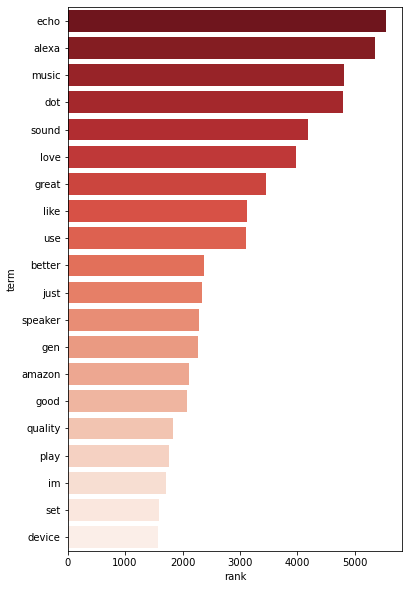

In [590]:
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0) 
    data = []
    for col, term in enumerate(terms): 
        data.append( (term, sums[0,col])) 
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank',ascending=False) 
    
    return ranked 

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fix, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette="Reds_r", ax=ax)

In [424]:
from sklearn.decomposition import LatentDirichletAllocation,NMF

n_topics= 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

topics= lda.fit_transform(tfidf)

top_n_words = 12
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] =[vectorizer.get_feature_names()[i] 
                    for i in t.argsort()[:-top_n_words -1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words-1:-1]]
t_words    

{0: ['alexa',
  'home',
  'echo',
  'dot',
  'smart',
  'generation',
  'amazon',
  'device',
  'im',
  'voice',
  'good',
  'time'],
 1: ['echo',
  'dot',
  'gen',
  'sound',
  '2nd',
  '3rd',
  'new',
  'better',
  'dots',
  'generation',
  'music',
  'quality'],
 2: ['great',
  'music',
  'play',
  'alexa',
  'works',
  'love',
  'ask',
  'product',
  'weather',
  'use',
  'just',
  'amazon'],
 3: ['use',
  'set',
  'easy',
  'just',
  'device',
  'alexa',
  'music',
  'like',
  'amazon',
  'things',
  'house',
  'im'],
 4: ['sound',
  'speaker',
  'good',
  'like',
  'quality',
  'better',
  'really',
  'little',
  'sounds',
  'voice',
  'dont',
  'product'],
 5: ['love',
  'work',
  'does',
  'room',
  'alexa',
  'doesnt',
  'bought',
  'time',
  'im',
  'music',
  'got',
  'dont']}

In [294]:
topics2= lda.fit(tfidf)

In [591]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics= 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

topics= lda.fit_transform(tfidf)

top_n_words = 6
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] =[vectorizer.get_feature_names()[i] 
                    for i in t.argsort()[:-top_n_words -1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words-1:-1]]
t_words    

{0: ['alexa', 'home', 'echo', 'dot', 'smart', 'generation'],
 1: ['echo', 'dot', 'gen', 'sound', '2nd', '3rd'],
 2: ['great', 'music', 'play', 'alexa', 'works', 'love'],
 3: ['use', 'set', 'easy', 'just', 'device', 'alexa'],
 4: ['sound', 'speaker', 'good', 'like', 'quality', 'better'],
 5: ['love', 'work', 'does', 'room', 'alexa', 'doesnt']}

In [427]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', vectorizer),
                ('lda',lda)])

document_id =11
t = pipe.transform([data['content'].iloc[document_id]])
print('문서 #{}에 대한 토픽 배분: \n'.format(document_id),t)
print('\n문서 #{}에 대한 주제 관련성 \n'.format(document_id),t.max(), )
print('\n자막:\n',data['content'].iloc[document_id][:500],"...")


문서 #11에 대한 토픽 배분: 
 [[0.03364041 0.03333626 0.03347909 0.03343754 0.03334132 0.83276538]]

문서 #11에 대한 주제 관련성 
 0.8327653789960421

자막:
 Never get it work Unpack it plug in and download the Alexa app The app keep saying connection time out The signin doesnt respond as well Soooooo dispointed ...


In [592]:
import pyLDAvis.sklearn

visual = pyLDAvis.sklearn.prepare(lda_model=lda, dtm=tfidf, vectorizer=vectorizer)
# pyLDAvis.save_html(visual, 'LDA_Visualization.html')
pyLDAvis.display(visual)

In [593]:
col=['Topic_'+str(i) for i in range(6)]

In [594]:
t= pipe.transform(data['content'])
t=pd.DataFrame(t, columns=col)
t.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.766996,0.042846,0.041843,0.042445,0.042618,0.063253
1,0.157229,0.049701,0.050863,0.331508,0.049526,0.361174
2,0.069612,0.069784,0.069824,0.069586,0.650398,0.070795
3,0.640664,0.049898,0.049675,0.049674,0.049854,0.160236
4,0.279722,0.052898,0.509122,0.053008,0.052544,0.052705


In [595]:
content_len=[]
for i in range(len(data['content'])):
    content_len.append(len(data['content'][i]))

In [224]:
content_len

[4503,
 357,
 162,
 554,
 709,
 52,
 222,
 370,
 224,
 86,
 3,
 165,
 151,
 182,
 59,
 358,
 238,
 411,
 466,
 132,
 158,
 445,
 511,
 208,
 180,
 1190,
 44,
 78,
 62,
 94,
 74,
 61,
 482,
 390,
 19,
 985,
 77,
 187,
 138,
 333,
 36,
 2866,
 122,
 287,
 275,
 515,
 238,
 191,
 237,
 76,
 443,
 345,
 62,
 257,
 495,
 596,
 901,
 267,
 92,
 102,
 295,
 190,
 61,
 69,
 821,
 934,
 135,
 146,
 246,
 82,
 111,
 2117,
 1313,
 131,
 649,
 160,
 386,
 49,
 116,
 111,
 149,
 249,
 99,
 305,
 55,
 168,
 37,
 894,
 115,
 131,
 184,
 229,
 139,
 1745,
 881,
 77,
 984,
 119,
 40,
 761,
 86,
 435,
 270,
 64,
 95,
 654,
 432,
 216,
 274,
 33,
 451,
 261,
 311,
 376,
 282,
 155,
 418,
 220,
 83,
 507,
 459,
 46,
 714,
 825,
 1300,
 2258,
 43,
 162,
 92,
 469,
 87,
 151,
 1212,
 180,
 35,
 94,
 38,
 99,
 94,
 241,
 54,
 223,
 181,
 112,
 44,
 1007,
 72,
 475,
 322,
 665,
 384,
 8,
 399,
 173,
 27,
 86,
 230,
 14,
 170,
 237,
 182,
 327,
 40,
 165,
 212,
 1094,
 590,
 69,
 313,
 96,
 80,
 616,
 208,
 67

In [596]:
topic_data=pd.concat([t,data['rating']],axis=1)

In [597]:
topic_data.loc[:,'content_len']=content_len
topic_data

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,rating,content_len
0,0.766996,0.042846,0.041843,0.042445,0.042618,0.063253,1,4425
1,0.157229,0.049701,0.050863,0.331508,0.049526,0.361174,3,351
2,0.069612,0.069784,0.069824,0.069586,0.650398,0.070795,2,162
3,0.640664,0.049898,0.049675,0.049674,0.049854,0.160236,2,546
4,0.279722,0.052898,0.509122,0.053008,0.052544,0.052705,2,692
...,...,...,...,...,...,...,...,...
15456,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,5,50
15457,0.057561,0.202898,0.057378,0.057278,0.567549,0.057336,5,54
15458,0.057760,0.057630,0.057448,0.057397,0.712060,0.057705,5,216
15459,0.061714,0.062144,0.689647,0.061811,0.062291,0.062393,5,148


In [598]:
topic_data=topic_data.drop(['Topic_4'],axis=1)

In [599]:
topic_data.to_csv('topic_data2.csv',index=False)

### Tomotopy LDA

In [537]:
import tomotopy as tp
from tqdm import tqdm

In [605]:
model = tp.LDAModel(k=6, alpha=0.1, eta=0.01, min_cf=5)


In [588]:
ss=tokenize(data['content'])

AttributeError: 'Series' object has no attribute 'lower'

In [579]:
len(data_words_nostops)

15461

In [606]:
for i in tqdm(data_words_nostops):
    model.add_doc(i)

100%|████████████████████████████████████████████████████████████████████████| 15461/15461 [00:00<00:00, 155823.51it/s]


In [607]:
model.train(0)
print('Total docs:', len(model.docs)) # 전체 문헌의 개수가 출력될 겁니다.
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)

Total docs: 15436
Total words: 308460
Vocab size: 3792


In [608]:
# 다음 구문은 train을 총 200회 반복하면서,
# 10회 마다로 로그 가능도 값을 출력해줍니다.
# 혹은 단순히 model.train(200)으로 200회 반복도 가능합니다.
for i in range(20):
    print('Iteration {}\tLL per word: {}'.format(i, model.ll_per_word))
    model.train(10)
  

Iteration 0	LL per word: -9.100217906049869
Iteration 1	LL per word: -7.766538418733863
Iteration 2	LL per word: -7.565928784296654
Iteration 3	LL per word: -7.439309188098456
Iteration 4	LL per word: -7.37504028357734
Iteration 5	LL per word: -7.3442711414968445
Iteration 6	LL per word: -7.319997048470549
Iteration 7	LL per word: -7.304067720684306
Iteration 8	LL per word: -7.290485945311315
Iteration 9	LL per word: -7.276948400453271
Iteration 10	LL per word: -7.265892413363382
Iteration 11	LL per word: -7.264094813846393
Iteration 12	LL per word: -7.252240488711115
Iteration 13	LL per word: -7.251005508465417
Iteration 14	LL per word: -7.2473507720677794
Iteration 15	LL per word: -7.247762990320273
Iteration 16	LL per word: -7.2384554954835165
Iteration 17	LL per word: -7.2351865579933845
Iteration 18	LL per word: -7.234153319292671
Iteration 19	LL per word: -7.2286197924869215


In [643]:
print(model.docs[1590].get_topics(top_n=10))


[(1, 0.4487563967704773), (2, 0.1737426221370697), (0, 0.15128348767757416), (3, 0.1403774619102478), (4, 0.04444921389222145), (5, 0.04139083996415138)]


In [646]:
print(model.get_topic_words(2, top_n=10))

[('great', 0.04497124254703522), ('love', 0.04004799202084541), ('echo', 0.034898754209280014), ('one', 0.0324774831533432), ('dot', 0.023680197075009346), ('sound', 0.022550269961357117), ('room', 0.017933711409568787), ('use', 0.01753016747534275), ('easy', 0.016884494572877884), ('works', 0.014882910065352917)]


In [648]:
model.docs[1590].get_topics(top_n=10)

[(1, 0.4487563967704773),
 (2, 0.1737426221370697),
 (0, 0.15128348767757416),
 (3, 0.1403774619102478),
 (4, 0.04444921389222145),
 (5, 0.04139083996415138)]

In [649]:
print(model.get_topic_words(5, top_n=10))

[('music', 0.0322352834045887), ('alexa', 0.024731121957302094), ('amazon', 0.022821323946118355), ('home', 0.022531960159540176), ('smart', 0.017767108976840973), ('google', 0.016956891864538193), ('use', 0.015587237663567066), ('play', 0.013156584464013577), ('like', 0.013060130178928375), ('echo', 0.01300225779414177)]


In [652]:
ss=[]
for i in data['content']:
    ss.append(i)

### 최종 토픽모델링 (Sklearn.lda)

In [430]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gommg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gommg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gommg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [667]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [685]:
stop_words.extend(['2nd','get','im','2rd','3rd','echo', 'dot', 'gen', 'generation', 'amazon','2'])

In [686]:
def tokenize(text):
   
   # normalize case and remove punctuation
   text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
   
   # tokenize text
   tokens = word_tokenize(text)
   
   # lemmatize and remove stop words
   tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
   
   return tokens

###모델에는 CountVectorizer 사용

In [687]:
from sklearn.feature_extraction.text import CountVectorizer

# initialize count vectorizer object
vect = CountVectorizer(tokenizer = tokenize,
                       stop_words=stop_words,
                       ngram_range=(1,1), 
                            min_df = 0.05,     
                            max_df = 0.55)

In [688]:
# get counts of each token(word) in text data
X = vect.fit_transform(data['content'])

In [689]:
X

<15461x46 sparse matrix of type '<class 'numpy.int64'>'
	with 73062 stored elements in Compressed Sparse Row format>

In [615]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize tf-idf vectorizer object
vectorizer = TfidfVectorizer(stop_words=stop_words,
                             tokenizer=tokenize,
                            use_idf=True,
                            ngram_range=(1,1), 
                            min_df = 0.05,     
                            max_df = 0.5)

In [616]:
X = vectorizer.fit_transform(data['content'])

In [617]:
X

<15461x56 sparse matrix of type '<class 'numpy.float64'>'
	with 90309 stored elements in Compressed Sparse Row format>

In [690]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics= 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=1)

topics= lda.fit_transform(X)

top_n_words = 6
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] =[vect.get_feature_names()[i] 
                    for i in t.argsort()[:-top_n_words -1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words-1:-1]]
t_words    

{0: ['alexa', 'device', 'home', 'smart', 'thing', 'great'],
 1: ['work', 'product', 'easy', 'great', 'use', 'set'],
 2: ['one', 'like', 'dont', 'would', 'know', 'time'],
 3: ['sound', 'speaker', 'better', 'quality', 'much', 'good'],
 4: ['love', 'music', 'play', 'alexa', 'ask', 'use'],
 5: ['room', 'house', 'light', 'use', 'music', 'need']}

In [530]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics= 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

topics= lda.fit_transform(X)

top_n_words = 6
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] =[vectorizer.get_feature_names()[i] 
                    for i in t.argsort()[:-top_n_words -1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words-1:-1]]
t_words    

{0: ['sound', 'dot', 'better', 'echo', 'gen', 'generation'],
 1: ['like', 'time', 'dont', 'alexa', 'doesnt', 'im'],
 2: ['good', 'music', 'play', 'got', 'thing', 'sound'],
 3: ['great', 'work', 'little', 'sound', 'device', 'product'],
 4: ['love', 'home', 'product', 'alexa', 'smart', 'bought'],
 5: ['easy', 'set', 'use', 'alexa', 'weather', 'question']}

In [716]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', vect),
                ('lda',lda)])

document_id =1234
t = pipe.transform([data['content'].iloc[document_id]])
print('문서 #{}에 대한 토픽 배분: \n'.format(document_id),t)
print('\n문서 #{}에 대한 주제 관련성 \n'.format(document_id),t.max(), )
print('\n자막:\n',data['content'].iloc[document_id][:500],"...")

문서 #1234에 대한 토픽 배분: 
 [[0.0421696  0.04169243 0.04172297 0.04169261 0.79094163 0.04178076]]

문서 #1234에 대한 주제 관련성 
 0.7909416330115916

자막:
 1 star bcause there is not zeronot understand the commandsnor the instructions although the instructions are given in few stepsex alexa play cristian castro music it is not worthy I had high expectations about it but it is in vainPlease try another marks google for instancethanks ...


In [692]:
import pyLDAvis.sklearn

visual = pyLDAvis.sklearn.prepare(lda_model=lda, dtm=X, vectorizer=vect)
# pyLDAvis.save_html(visual, 'LDA_Visualization.html')
pyLDAvis.display(visual)

In [531]:
import pyLDAvis.sklearn

visual = pyLDAvis.sklearn.prepare(lda_model=lda, dtm=X, vectorizer=vectorizer)
# pyLDAvis.save_html(visual, 'LDA_Visualization.html')
pyLDAvis.display(visual)

In [708]:
col=['Topic_'+str(i) for i in range(6)]
t= pipe.transform(data['content'])
t=pd.DataFrame(t, columns=col)

topic_data=pd.concat([t,data['rating']],axis=1)
topic_data.loc[:,'content_len']=content_len
topic_data.loc[:,'content_len']=MinMaxScaler().fit_transform(topic_data[['content_len']])
topic_data

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,rating,content_len
0,0.775578,0.003165,0.140468,0.074423,0.003187,0.003179,1,0.839499
1,0.015274,0.213553,0.199856,0.266493,0.289616,0.015208,3,0.066591
2,0.042120,0.041949,0.042255,0.041849,0.041923,0.789903,2,0.030734
3,0.033791,0.033334,0.297043,0.033359,0.569063,0.033409,2,0.103586
4,0.008475,0.008341,0.488732,0.008356,0.477735,0.008361,2,0.131284
...,...,...,...,...,...,...,...,...
15456,0.083334,0.083335,0.583113,0.083412,0.083343,0.083463,5,0.009486
15457,0.033399,0.393483,0.034226,0.033480,0.472061,0.033351,5,0.010245
15458,0.616462,0.033358,0.033856,0.249238,0.033496,0.033591,5,0.040979
15459,0.385117,0.033343,0.033526,0.033354,0.033548,0.481113,5,0.028078


In [710]:
topic_data=topic_data.drop(['Topic_5'],axis=1)

In [722]:
topic_data


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,rating,content_len
0,0.775578,0.003165,0.140468,0.074423,0.003187,1,0.839499
1,0.015274,0.213553,0.199856,0.266493,0.289616,3,0.066591
2,0.042120,0.041949,0.042255,0.041849,0.041923,2,0.030734
3,0.033791,0.033334,0.297043,0.033359,0.569063,2,0.103586
4,0.008475,0.008341,0.488732,0.008356,0.477735,2,0.131284
...,...,...,...,...,...,...,...
15456,0.083334,0.083335,0.583113,0.083412,0.083343,5,0.009486
15457,0.033399,0.393483,0.034226,0.033480,0.472061,5,0.010245
15458,0.616462,0.033358,0.033856,0.249238,0.033496,5,0.040979
15459,0.385117,0.033343,0.033526,0.033354,0.033548,5,0.028078


In [711]:
topic_data.to_csv('topic_data2.csv',index=False)